In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

### Everything related to LLH contributions, data set characterization etc

In [2]:
#!/bin/env python
from __future__ import print_function

import sys, os
import socket
import time
import numpy as np
import healpy as hp

from argparse import ArgumentParser
from collections import defaultdict

#Skylab
from skylab.psLLH import MultiPointSourceLLH, PointSourceLLH
from skylab.ps_model import EnergyLLH
from skylab.prior_injector import PriorInjector
from skylab.utils import rotate, kernel_func
from skylab.prior_generator import UhecrPriorGenerator

# Misc
from ic_data import load_data, prepare_directory

# Plotting
import seaborn as sns
import ic_utils as utils
plt = utils.plotting("pdf")

In [3]:
samples = ["IC40", "IC59", "IC79", "IC86-2011", "IC86-2012-2014"]

In [4]:
basepath, inipath, savepath, crpath, figurepath = utils.get_paths(socket.gethostname())

nsideparam = 6
job = 0
nsamples = 7
burn = False
niter = 1
followupfactor = 2

hemispheres = dict(North = np.radians([-5., 90.]), South = np.radians([-90., -5.]))
nside = 2**nsideparam
ncpu = 1

# Generate several templates for prior fitting
# One for each deflection hypothesis each
md_params = [6.]
pg = UhecrPriorGenerator(nsideparam)
log_tm = []
tm = []
for md in md_params:
    temp = pg.calc_template(np.radians(md), pg._get_UHECR_positions(85, crpath))
    log_tm.extend(temp)
    temp = np.exp(temp)
    tm.extend(temp/temp.sum(axis=1)[np.newaxis].T)
log_tm = np.array(log_tm)
tm = np.array(tm)
energies = pg.energy

startup_dict = dict(basepath = basepath,
                    inipath = inipath,
                    seed = job,
                    Nsrc = 0, ### Background ###
                    fixed_gamma = True,
                    add_prior = True,
                    src_gamma = 2.,
                    fit_gamma = 2.,
                    multi = True if nsamples>1 else False,
                    n_uhecr = pg.n_uhecr,
                    # prior = tm1, # not needed for Background
                    nside_param = nsideparam,
                    burn = burn,
                    ncpu = ncpu,
                    n_samples = nsamples,
                    mode = "box")

In [5]:
llh, injector = utils.startup(**startup_dict)

## HotSpot

In [39]:
scan_dict = dict(mu = None,  
                    nside = nside,
                    follow_up_factor = followupfactor,
                    pVal = None,
                    fit_gamma = 2.)

for i, (scan, hotspots1) in enumerate(llh.all_sky_scan(hemispheres=hemispheres,
                                prior=log_tm,
                                **scan_dict)
                                ):
        if followupfactor == 0: break # In case you don't want a follow-up
        print("Next follow-up")
        if i > 0:
            # break after first follow up
            break

In [ ]:
hk = hemispheres.keys()
print("Hemisphere keys:", hk)
best_hotspots = np.zeros(pg.n_uhecr*len(md_params),
                         dtype=[(p, np.float) for p in hk]
                                            +[("best", np.float)]
                                            +[("dec", np.float)]
                                            +[("ra", np.float)]
                                            +[("nsources", np.float)])

for i,hi in enumerate(hotspots):
    for h in hk:
        best_hotspots[h][i] = hi[h]["best"]["TS"]
    if best_hotspots[hk[0]][i] >= best_hotspots[hk[1]][i]:
        best_hotspots["best"][i] = best_hotspots[hk[0]][i]
        best_hotspots["ra"][i] = hi[hk[0]]["best"]["ra"]
        best_hotspots["dec"][i] = hi[hk[0]]["best"]["dec"]
        best_hotspots["nsources"][i] = hi[hk[0]]["best"]["nsources"]
    else:
        best_hotspots["best"][i] = best_hotspots[hk[1]][i]
        best_hotspots["ra"][i] = hi[hk[1]]["best"]["ra"]
        best_hotspots["dec"][i] = hi[hk[1]]["best"]["dec"]
        best_hotspots["nsources"][i] = hi[hk[1]]["best"]["nsources"]

print("Hotspots:")
print(best_hotspots.dtype.names)
print(best_hotspots)

In [42]:
nsouth = 0
nnorth = 0
for hsp in hotspots1:
    if hsp['North']['fit']['TS']>hsp['South']['fit']['TS']:
        print("North")
        nnorth+=1
        print((hsp['North']['grid']['TS']-hsp['North']['fit']['TS'])/hsp['North']['fit']['TS'])

    else:
        print("South")
        nsouth+=1
        print((hsp['South']['grid']['TS']-hsp['South']['fit']['TS'])/hsp['South']['fit']['TS'])
print("North:", nnorth, ", South:", nsouth)

hk = hemispheres.keys()
for k in hk:
    print(k)
    for hsp1, hsp2 in zip(hotspots1, hotspots):
        print(1-hsp2[k]['fit']['TS']/hsp1[k]['fit']['TS'])

South
-0.0486168095649
South
-0.0045520397018
North
-0.0126938364198
North
-0.0172251472198
North
-0.000475705571996
North
-0.0666464794674
North
-0.0111037736777
North
-0.0131972170545
North
-0.00732156896748
North: 7 , South: 2


# PDF plotting 

## declination acceptance

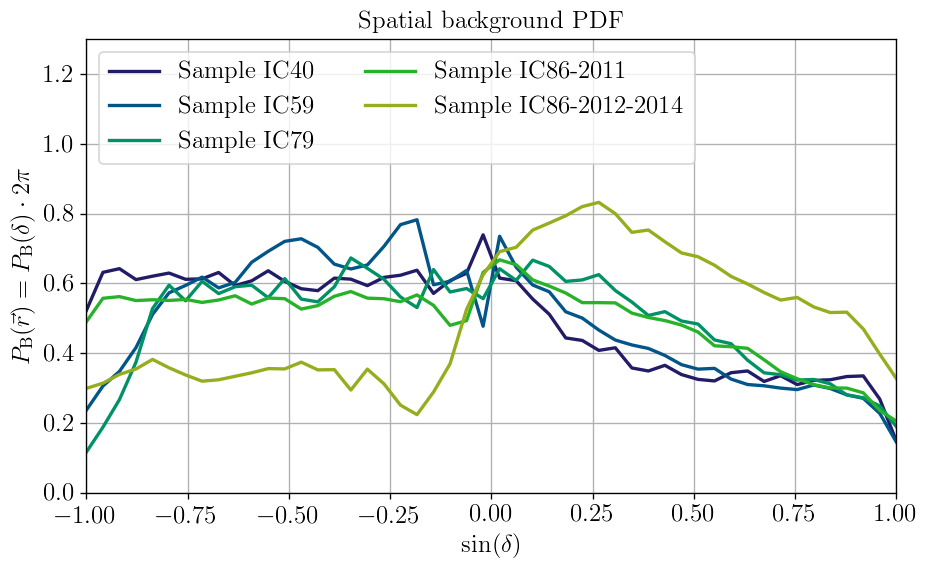

In [205]:
sindec = np.linspace(-1,1,num=50)

for k in llh._samples.keys()[:min(5,len(llh._samples))]:
    plt.figure(1)
    llm=llh._samples[k].llh_model
    bckg_spline = kernel_func(llm._bckg_spline, None)
    plt.plot(sindec, np.exp(bckg_spline(sindec)), label="Sample "+str(samples[k]))

plt.title(r"Spatial background PDF")
plt.xlabel(r"sin($\delta$)")
plt.ylabel(r"$P_\mathrm{B}(\vec{r})=P_\mathrm{B}(\delta)\cdot 2\pi$")
plt.xlim(-1,1)
plt.ylim(0,1.3)
plt.legend(ncol=2, loc=2)

plt.show()

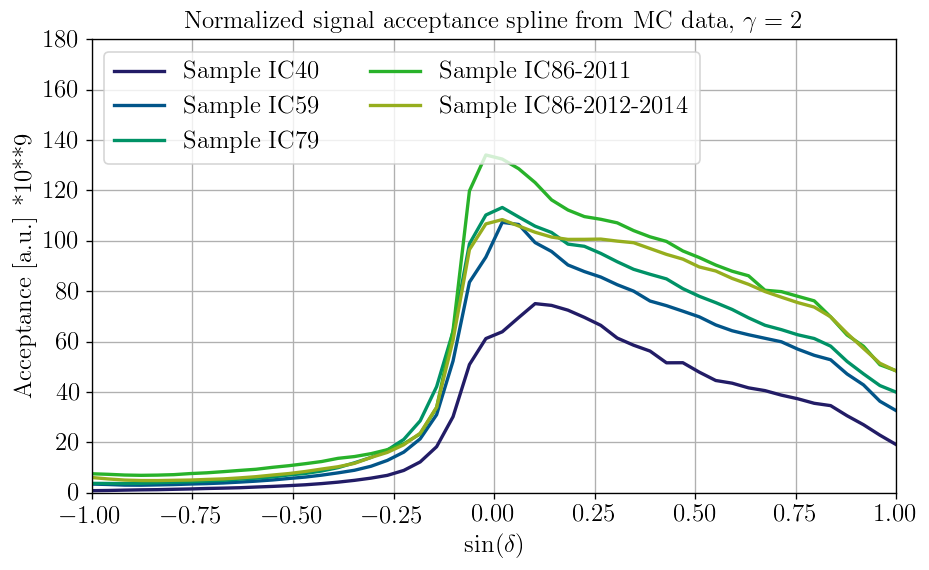

In [224]:
sindec = np.linspace(-1,1,num=50)
gamma=2

for k in llh._samples.keys()[:min(5,len(llh._samples))]:
    plt.figure(1)
    effA_spline = llh._samples[k].llh_model._spl_effA
    plt.plot(sindec, np.exp(effA_spline(sindec, gamma))/(10**9), label="Sample "+str(samples[k]))

plt.title(r"Normalized signal acceptance spline from MC data, $\gamma=2$")
plt.xlabel(r"sin($\delta$)")
plt.ylabel(r"Acceptance [a.u.] *10**9")
plt.xlim(-1,1)
plt.ylim(0,180)
plt.legend(ncol=2, loc=2)

plt.show()

## Signal prior

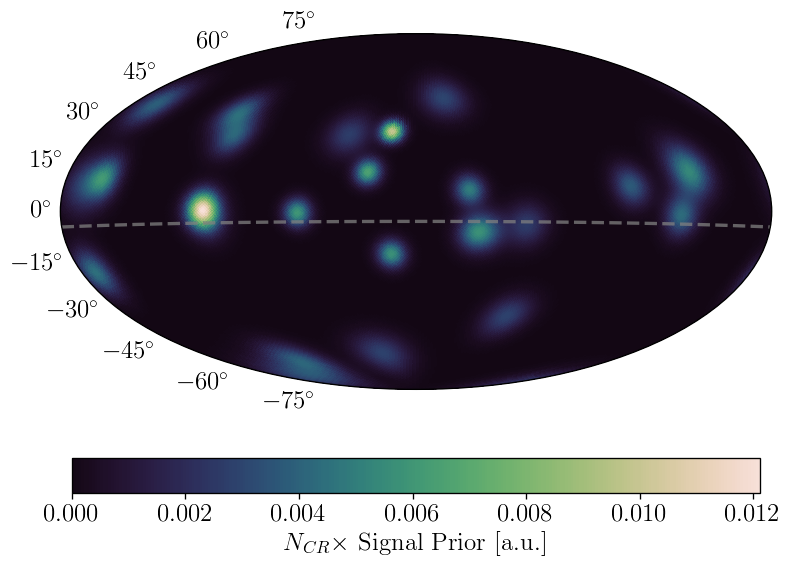

In [206]:
utils.skymap(plt, sum(tm), cmap=utils.cmap, colorbar=dict(title=r"$N_{CR} \times $ Signal Prior [a.u.]"))
plt.show()

## Signal/Background weight ratio 

In [219]:
from matplotlib.colors import LogNorm

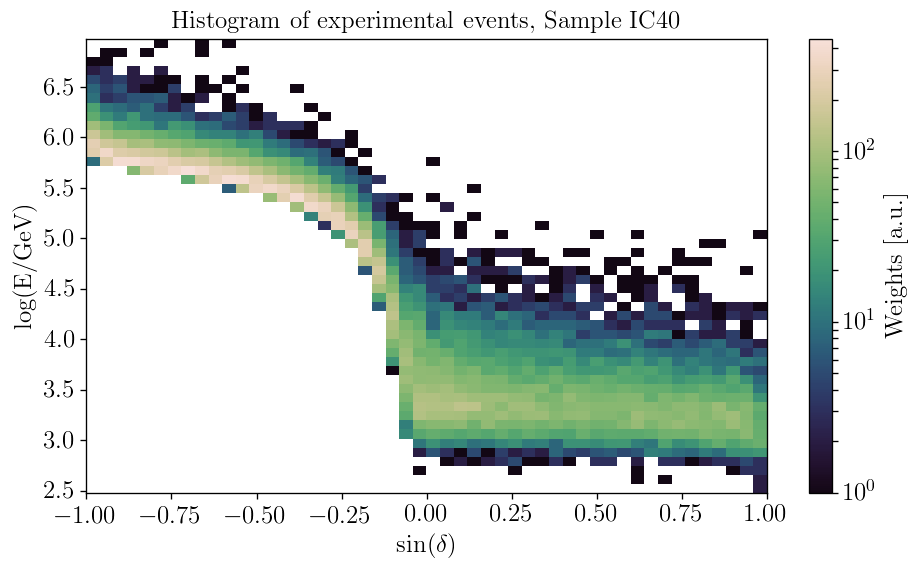

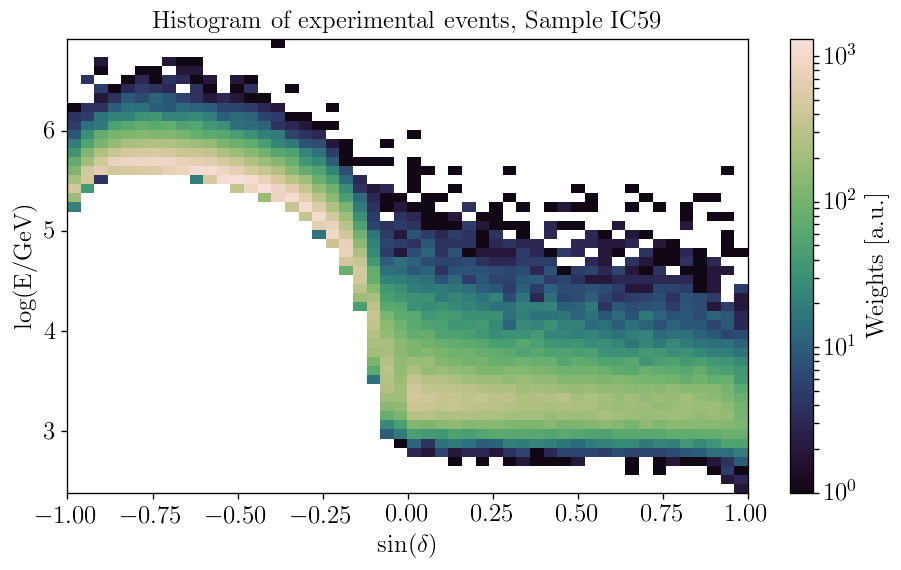

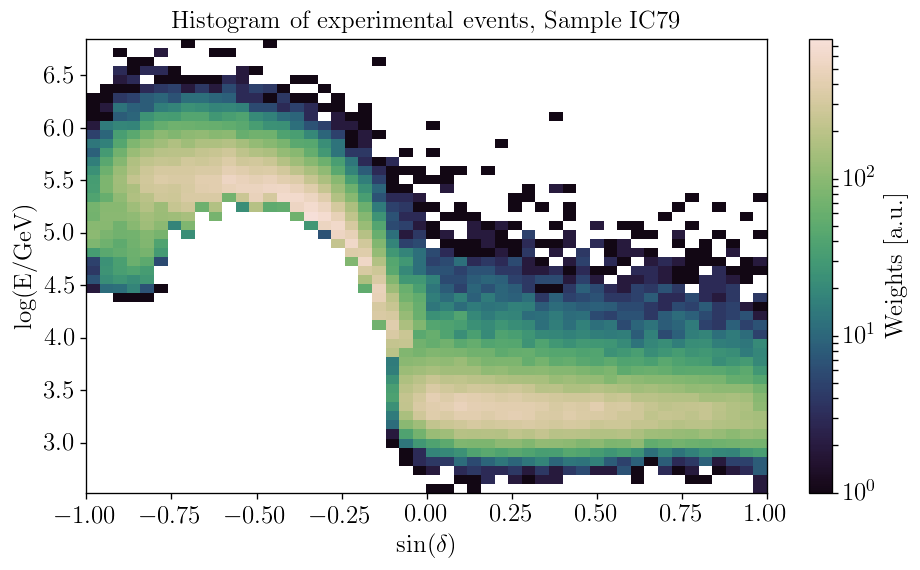

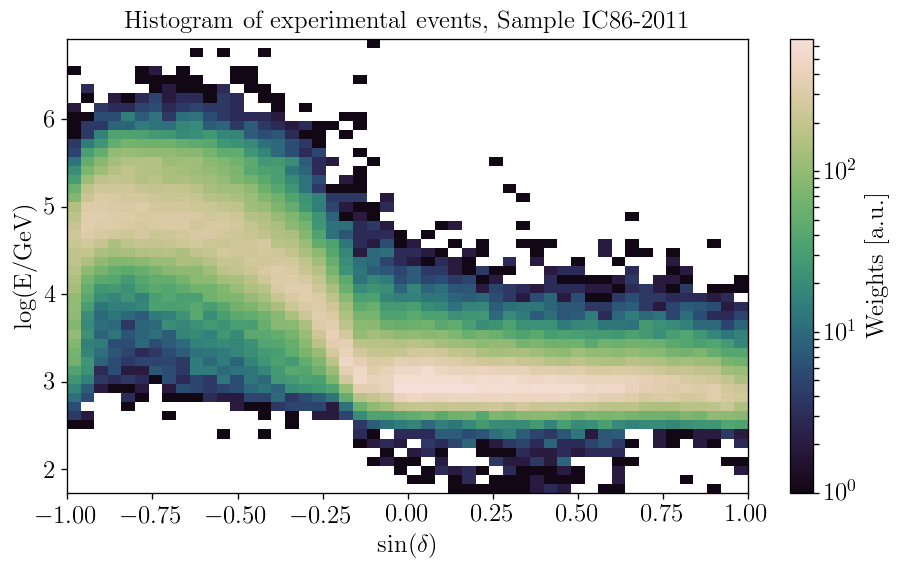

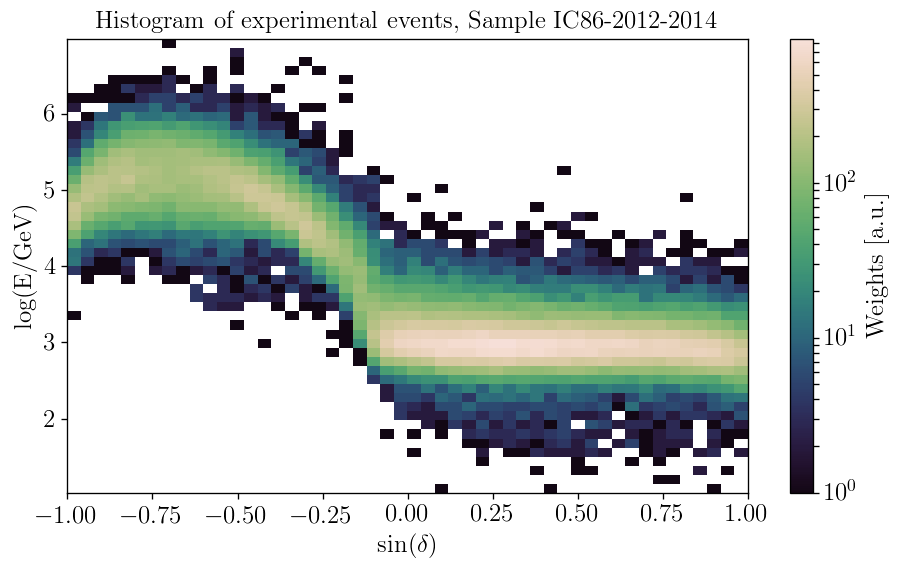

In [223]:
for k in llh._samples.keys()[:min(5,len(llh._samples))]:
    f = plt.figure(int(k))
    llh_i = llh._samples[k]
    plt.hist2d(llh_i.exp['sinDec'], llh_i.exp['logE'], 
               bins=50,
               cmap=utils.cmap,
               norm=LogNorm()
              )
    plt.grid(False)
    cbar = plt.colorbar()
    cbar.set_label("Weights [a.u.]")
    plt.title(r"Histogram of experimental events, Sample "+str(samples[k]))
    plt.ylabel(r"log(E/GeV)")
    plt.xlabel(r"sin($\delta$)")
plt.show()

(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)
(50, 50) (50, 50)


/.automount/home/home__home2/institut_3b/lschumacher/my_virtual_envs/my_skylab/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


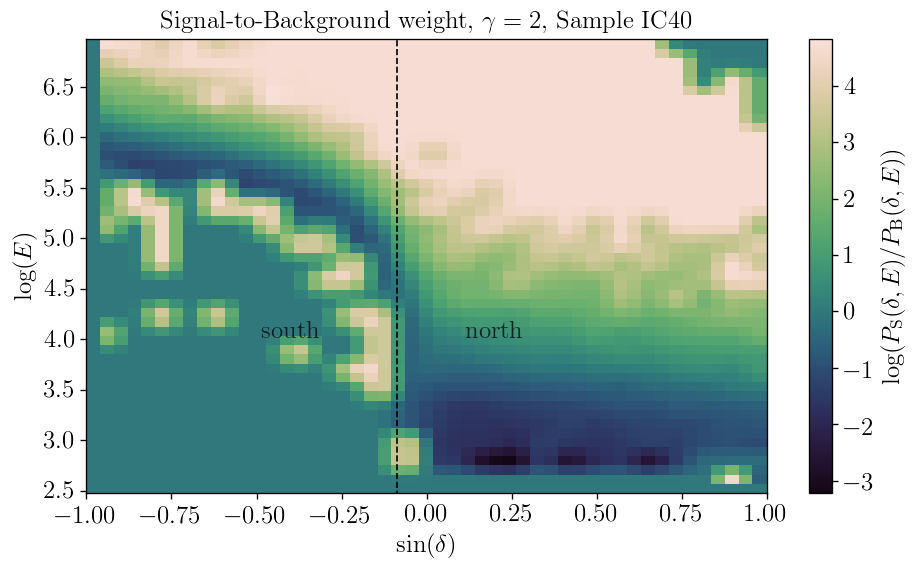

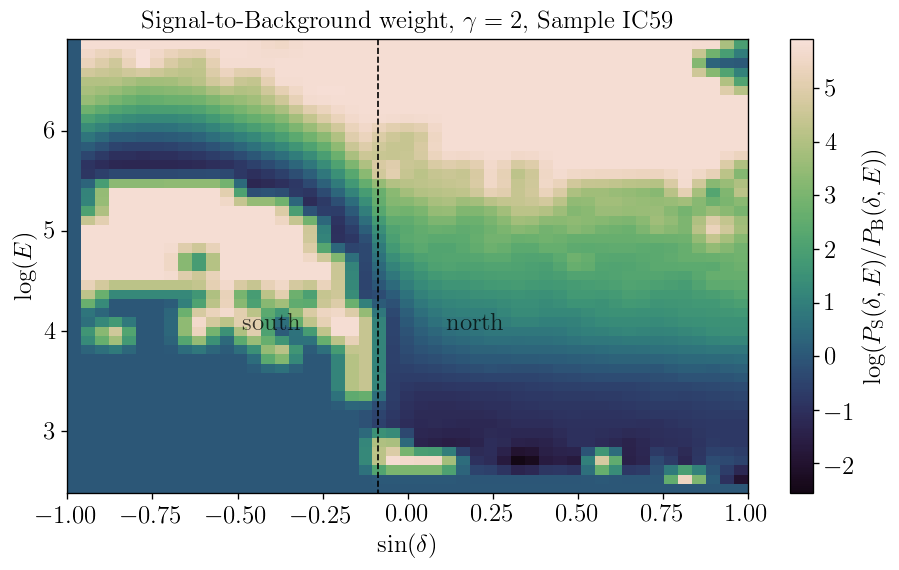

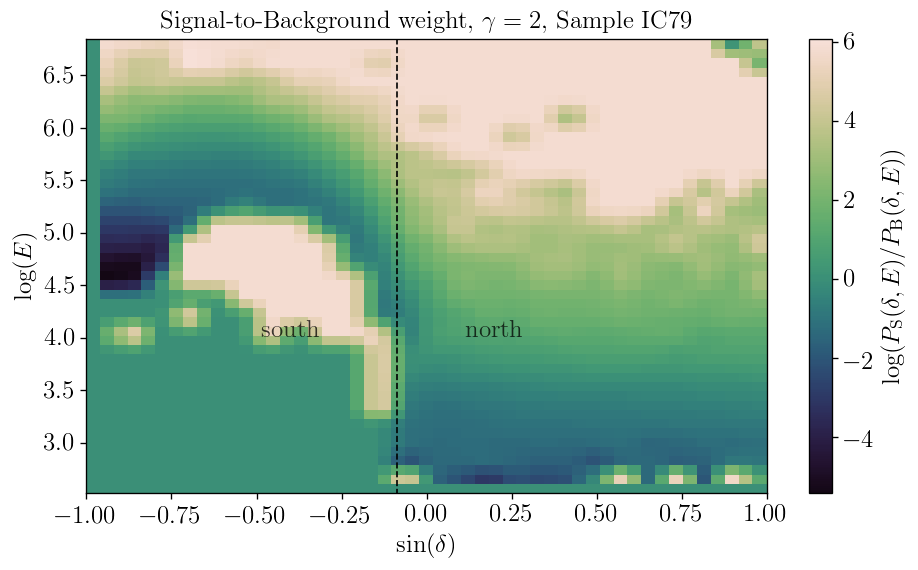

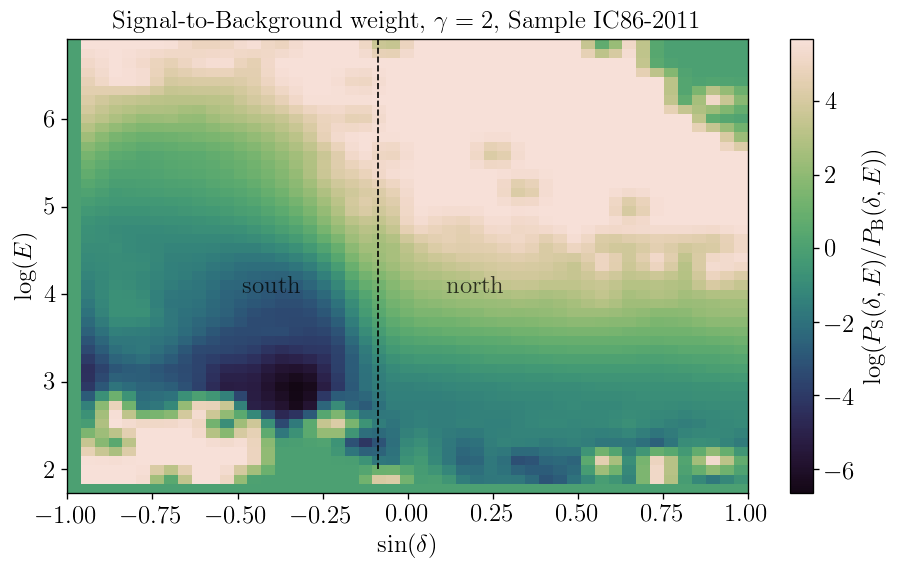

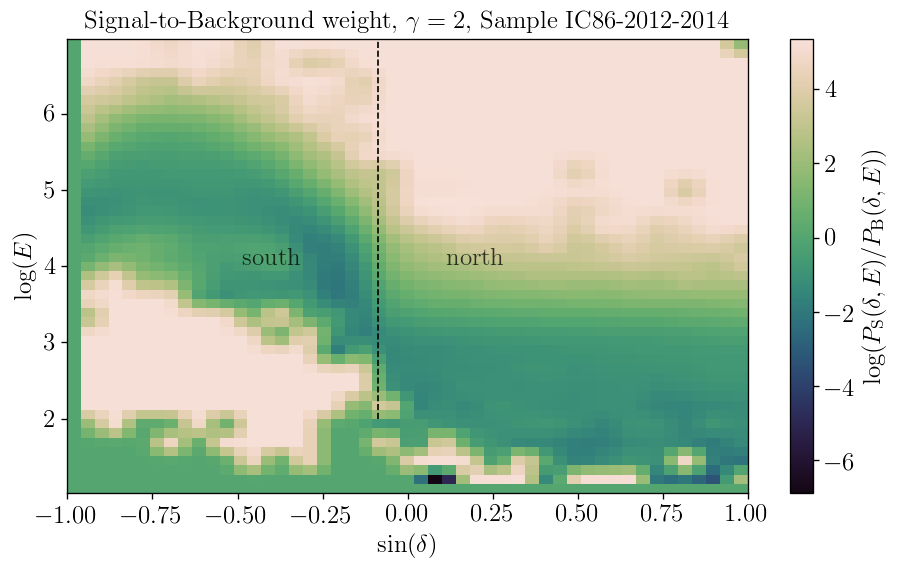

In [6]:
horizon = np.sin(np.radians(-5))

size=50
ra = np.linspace(0, np.pi*2., size)
sin_dec = np.linspace(-1, 1, size)
for k in llh._samples.keys()[:min(5,len(llh._samples))]:
    f = plt.figure(int(k))
    llh_i = llh._samples[k]
    min_e_exp = min(llh_i.exp['logE'])
    max_e_exp = max(llh_i.exp['logE'])
    logE = np.linspace(min_e_exp, max_e_exp, size)

    ll_model = llh_i.llh_model

    X,Y = np.meshgrid(sin_dec, logE)
    Z = np.empty_like(X)
    print(np.shape(X), np.shape(Y))

    for i in range(len(Z)):
        for j in range(len(Z[i])):
            Z[i][j]=ll_model._spline_eval(ll_model._w_spline_dict[(("gamma", 2), )], {'sinDec' : X[i][j], 'logE' : Y[i][j]})

    ax = plt.subplot()
    im=ax.pcolormesh(X, Y, Z, cmap=utils.cmap, vmin=np.min(Z), vmax=np.max(Z)) #cmap=colormaps.viridis)
    f.colorbar(im, label=r"$\log(P_\mathrm{S}(\delta, E)/P_\mathrm{B}(\delta, E))$")
    plt.vlines(horizon, 2, max_e_exp, lw=1, linestyles="--") #, label="horizon")
    plt.text(horizon+0.2, 4, "north", alpha=0.75)
    plt.text(horizon-0.4, 4, "south", alpha=0.75)
    plt.xlabel(r'$\sin(\delta)$')
    plt.ylabel(r'$\log(E)$')
    plt.title(r"Signal-to-Background weight, $\gamma=2$, Sample "+str(samples[k]))
    plt.xlim(np.min(X), np.max(X))
    plt.ylim(np.min(Y), np.max(Y))
#plt.savefig(os.path.join(save, "test_signal_to_background.png"))
plt.show()

# LLH plotting 

## Signal 

In [12]:
sampler = injector.sample(5.*len(injector.uhecr_dec))

In [14]:
res = multi_llh.fit_source(injector.uhecr_ra, injector.uhecr_dec, src_sigma=injector.uhecr_sigma, inject=sampler.next()[-1])

print(res)

In [71]:
nsource = np.linspace(500, 1500, num=50)
gamma = np.linspace(2.2, 2.8, num=50)
X,Y = np.meshgrid(nsource, gamma)
Z = np.empty_like(X)
print(np.shape(X), np.shape(Y))

for i in range(len(Z)):
    for j in range(len(Z[i])):
        Z[i][j]=-1.*multi_llh.llh(nsources=X[i][j], gamma=Y[i][j])[0]

z_min = np.min(Z)
print(z_min)

(50, 50) (50, 50)


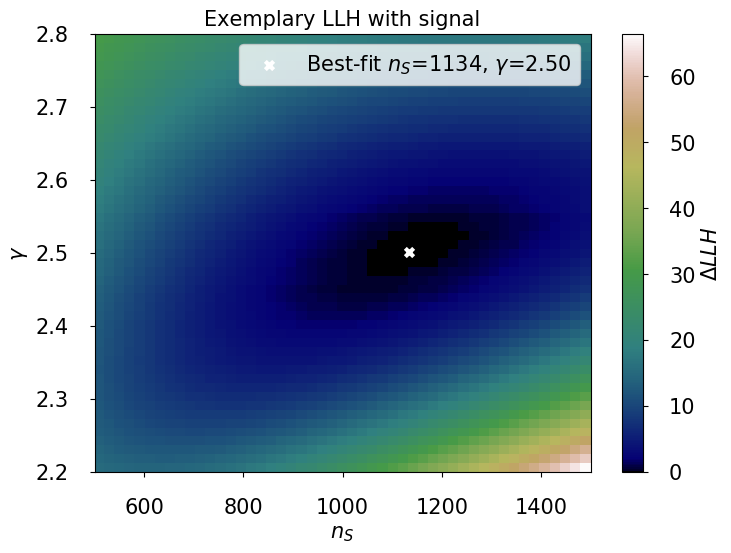

In [78]:
f = plt.figure(1)
ax = plt.subplot()

im=ax.pcolormesh(X, Y, Z-z_min, cmap='gist_earth') #cmap=colormaps.viridis)
f.colorbar(im, label=r"$\Delta LLH$")
plt.scatter(res[1]['nsources'], 
            res[1]['gamma'], 
            color="white", 
            marker="x",
            label=r"Best-fit $n_S$={:1.0f}, $\gamma$={:1.2f}".format(res[1]['nsources'], res[1]['gamma'])
           )
plt.xlabel(r'$n_S$')
plt.ylabel(r'$\gamma$')
plt.title("Exemplary LLH with signal")
plt.legend()
plt.savefig(os.path.join(save, "test_llh_signal.png"))
plt.show()

## Background

In [79]:
res = multi_llh.fit_source(injector.uhecr_ra, injector.uhecr_dec, src_sigma=injector.uhecr_sigma)
print(res)

(0.051001216557142126, {'nsources': 49.921015165244505, 'gamma': 2.8021037478933737})


In [80]:
nsource = np.linspace(0, 500, num=20)
gamma = np.linspace(2.6, 3.0, num=20)
X,Y = np.meshgrid(nsource, gamma)
Z = np.empty_like(X)
print(np.shape(X), np.shape(Y))

for i in range(len(Z)):
    for j in range(len(Z[i])):
        Z[i][j]=-1.*multi_llh.llh(nsources=X[i][j], gamma=Y[i][j])[0]

z_min = np.min(Z)
print(z_min)

(20, 20) (20, 20)
-0.0530628765677


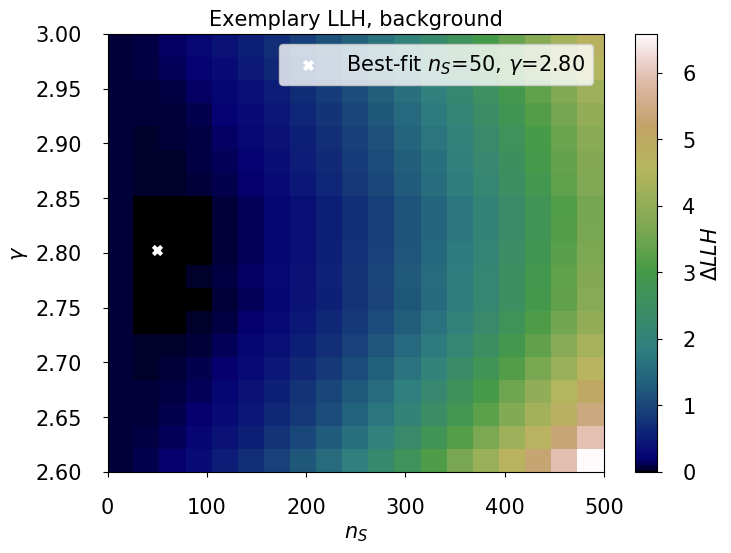

In [81]:
f = plt.figure(2)
ax = plt.subplot()

im=ax.pcolormesh(X, Y, Z-z_min, cmap='gist_earth') #cmap=colormaps.viridis)
f.colorbar(im, label=r"$\Delta LLH$")
plt.scatter(res[1]['nsources'], 
            res[1]['gamma'], 
            color="white", 
            marker="x",
            label=r"Best-fit $n_S$={:1.0f}, $\gamma$={:1.2f}".format(res[1]['nsources'], res[1]['gamma'])
           )
plt.xlabel(r'$n_S$')
plt.ylabel(r'$\gamma$')
plt.title("Exemplary LLH, background")
plt.legend()
plt.savefig(os.path.join(save, "test_llh_bg.png"))
plt.show()